In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

In [23]:
# Read the cleaned data CSV file into pandas DataFrame
data = pd.read_csv("Cleaned_forex_data.csv")

In [24]:
# Calculate RSI
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean().abs()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
data['rsi'] = rsi

In [25]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :-1])
        y.append(data[i + sequence_length, -1])
    return np.array(X), np.array(y)

In [26]:
data['label'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data = data.dropna()

In [27]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'label'], dtype='object')

In [28]:
# Define the sequence length and create sequences
sequence_length = 50
data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'label']]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
X, y = create_sequences(data, sequence_length)

In [29]:
# Split the data into training, validation, and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, shuffle=False)

In [30]:
# Define the input shape
input_shape = (train_X.shape[1], train_X.shape[2])


In [31]:
# Define the LSTM model
lstm_input = Input(shape=input_shape)
lstm_layer = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(lstm_input)

In [32]:
# Define the CNN model
cnn_input = Input(shape=input_shape)
cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(0.2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

In [33]:

# Concatenate the LSTM and CNN models
merged = concatenate([lstm_layer, cnn_layer])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2)(merged)
output = Dense(3, activation='softmax')(merged)

In [34]:


train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

In [53]:
from keras.layers import LeakyReLU, Dropout

learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    model = Sequential()
    model.add(Conv1D(64, 3, activation='linear', input_shape=(50, 6)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv1D(64, 3, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 3, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv1D(128, 3, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv1D(256, 3, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv1D(256, 3, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=1)

Epoch 1/50
298/298 [==============================] - 20s 63ms/step - loss: 0.9782 - accuracy: 0.5119 - val_loss: 0.6935 - val_accuracy: 0.5207
Epoch 2/50
298/298 [==============================] - 20s 67ms/step - loss: 0.6944 - accuracy: 0.5131 - val_loss: 0.6947 - val_accuracy: 0.4793
Epoch 3/50
298/298 [==============================] - 21s 70ms/step - loss: 0.6940 - accuracy: 0.5206 - val_loss: 0.6926 - val_accuracy: 0.5207
Epoch 4/50
298/298 [==============================] - 20s 68ms/step - loss: 47653.5039 - accuracy: 0.5037 - val_loss: 667.0616 - val_accuracy: 0.5207
Epoch 5/50
298/298 [==============================] - 21s 69ms/step - loss: 420.3158 - accuracy: 0.5056 - val_loss: 93.3551 - val_accuracy: 0.5207
Epoch 6/50
298/298 [==============================] - 21s 69ms/step - loss: 194.7952 - accuracy: 0.4948 - val_loss: 74.9088 - val_accuracy: 0.4793
Epoch 7/50
298/298 [==============================] - 23s 76ms/step - loss: 133.0504 - accuracy: 0.4994 - val_loss: 58.5543 

KeyboardInterrupt: 

In [42]:
# opt = Adam(learning_rate=0.001)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# history = model.fit([train_X, train_X], train_y, epochs=50, batch_size=32, validation_data=([val_X, val_X], val_y))

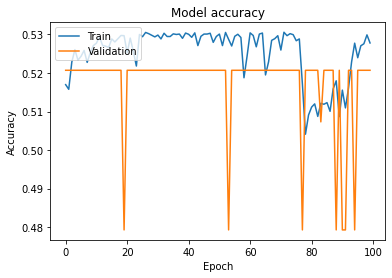

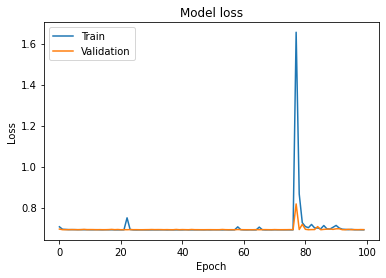

In [51]:


# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
val_loss, val_acc = model.evaluate(val_X, val_y)
print("Validation accuracy:", val_acc)

199/199 [==============================] - 2s 10ms/step - loss: 0.6928 - accuracy: 0.5207
Validation accuracy: 0.5207118988037109


In [45]:
y_pred = model.predict(test_X)

In [46]:
y_pred = np.argmax(y_pred, axis=1)

In [47]:
test_y = np.argmax(test_y, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1